In [1]:
import numpy as np
import nengo
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import nni
import pickle
import json
from scipy.stats import entropy
from model import Inputs, build_network, run_once

palette = sns.color_palette("colorblind")
sns.set_palette(palette)
sns.set(context='paper', style='ticks', font="CMU Serif", rc={'font.size':12, 'mathtext.fontset': 'cm'})

In [2]:
def chi_squared_distance(a,b):
    distance = 0
    a = a / np.sum(a)
    b = b / np.sum(b)
    for i in range(len(a)):
        if a[i]+b[i]==0:
            continue
        else:
            distance += np.square(a[i] - b[i]) / (a[i]+b[i])
    return distance

def get_loss(simulated, empirical):
    # return np.abs(simulated - empirical)
#     print('simulated', simulated)
#     print('empirical', empirical)
#     loss = np.sum(np.abs(simulated - empirical))
#     loss = 1 - entropy(simulated, empirical)
    loss = chi_squared_distance(simulated, empirical)
#     print('loss', loss)
    return loss

def run_all_trials(args, deltaPs=[0.1, 0.2, 0.4], nTr=None):
    # each participant has a participant ID (a long string) and an associated "pid" (integer) in the database
    # load this data to compute the loss between simulated and model behavior

    pid = args['pid']  # tria.suggest_int('pid', 1)
    T = args['T']
    m = args['m']
    tau = args['tau']
    delta = args['delta']
    seed = args['seed']  # pid
    
    with open('data/pids.pkl', 'rb') as f:
        pids = pickle.load(f)
    participant_ID = pids[pid]

    dfs = []
    columns = ('agent', 'dP', 'trial', 'cues', 'correct')
    for dP in deltaPs:
        empirical = pd.read_pickle("data/empirical.pkl").query("maxSamples==12 & delta==@dP & participant_id==@participant_ID")
        empirical_cues = empirical['cues'].to_numpy()
        empirical_accuracy = empirical['correct'].to_numpy()
        empirical_hist = np.histogram(empirical['cues'].to_numpy(), bins=np.arange(0, 27, 3))[0]
        nTrials = empirical.shape[0] if not nTr else nTr
        
        simulated_cues = []
        simulated_accuracy = []
        inputs = Inputs(deltaP=dP, maxCues=12, seed=pid, empirical=empirical)
        net = build_network(inputs, seed=seed, T=T, m=m, tau=tau, delta=delta)
        for trial in range(nTrials):
            print(f"deltaP={dP}, trial={trial}")
            net.inputs.set_AB(trial=trial)
            is_correct, cues_sampled = run_once(net)
            dfs.append(pd.DataFrame([['model', dP, trial, cues_sampled, 1.0*is_correct,]], columns=columns))
            dfs.append(pd.DataFrame([['human', dP, trial, empirical_cues[trial], 1.0*empirical_accuracy[trial]]], columns=columns))
            simulated_cues.append(cues_sampled)
        simulated_hist = np.histogram(simulated_cues, bins=np.arange(0, 27, 3))[0]
        total_loss = get_loss(simulated_hist, empirical_hist)
        
    data = pd.concat(dfs, ignore_index=True)
    data.to_pickle(f"data/{args['name']}_results.pkl")
    
def plot(name_fast, name_slow, name_output="individual"):
    fast_data = pd.read_pickle(f"data/{name_fast}_results.pkl")
    slow_data = pd.read_pickle(f"data/{name_slow}_results.pkl")
    fig, axes = plt.subplots(nrows=2, ncols=3, sharey=True, sharex=True, figsize=((7.07, 3)))
    sns.histplot(data=fast_data.query("dP==0.4"), x='cues', hue='agent', bins=np.arange(0, 27, 3), hue_order=["human", "model"],
        palette=palette[:2], ax=axes[0][0], stat='percent', multiple='layer', element='step', linewidth=1)
    sns.histplot(data=fast_data.query("dP==0.2"), x='cues', hue='agent', bins=np.arange(0, 27, 3), hue_order=["human", "model"],
        palette=palette[:2], ax=axes[0][1], stat='percent', multiple='layer', element='step', linewidth=1)
    sns.histplot(data=fast_data.query("dP==0.1"), x='cues', hue='agent', bins=np.arange(0, 27, 3), hue_order=["human", "model"],
        palette=palette[:2], ax=axes[0][2], stat='percent', multiple='layer', element='step', linewidth=1)
    axes[0][0].get_legend().remove()
    axes[0][1].get_legend().remove()
    axes[0][2].get_legend().remove()
    easy_human = int(100*fast_data.query("dP==0.4 & agent=='human'")['correct'].mean())
    moderate_human = int(100*fast_data.query("dP==0.2 & agent=='human'")['correct'].mean())
    hard_human = int(100*fast_data.query("dP==0.1 & agent=='human'")['correct'].mean())
    easy_model = int(100*fast_data.query("dP==0.4 & agent=='model'")['correct'].mean())
    moderate_model = int(100*fast_data.query("dP==0.2 & agent=='model'")['correct'].mean())
    hard_model = int(100*fast_data.query("dP==0.1 & agent=='model'")['correct'].mean())
    sns.lineplot(x=[0],y=[0], color=palette[0], label=f"{easy_human}%", ax=axes[0][0])
    sns.lineplot(x=[0],y=[0], color=palette[0], label=f"{moderate_human}%", ax=axes[0][1])
    sns.lineplot(x=[0],y=[0], color=palette[0], label=f"{hard_human}%", ax=axes[0][2])
    sns.lineplot(x=[0],y=[0], color=palette[1], label=f"{easy_model}%", ax=axes[0][0])
    sns.lineplot(x=[0],y=[0], color=palette[1], label=f"{moderate_model}%", ax=axes[0][1])
    sns.lineplot(x=[0],y=[0], color=palette[1], label=f"{hard_model}%", ax=axes[0][2])
    axes[0][0].set(xlabel=None, title="Easy", ylabel="Frequency (%)", yticks=((0, 5, 10, 15, 20, 25)))
    axes[0][1].set(xlabel=None, title="Moderate")
    axes[0][2].set(xlabel=None, title="Hard")
#     axlabel = axes[0][2].twinx()
#     axlabel.set(yticks=(()))
#     axlabel.set_ylabel('Fast\nIndividual', rotation=270)
    
    sns.histplot(data=slow_data.query("dP==0.4"), x='cues', hue='agent', bins=np.arange(0, 27, 3), hue_order=["human", "model"],
        palette=palette[:2], ax=axes[1][0], stat='percent', multiple='layer', element='step', linewidth=1)
    sns.histplot(data=slow_data.query("dP==0.2"), x='cues', hue='agent', bins=np.arange(0, 27, 3), hue_order=["human", "model"],
        palette=palette[:2], ax=axes[1][1], stat='percent', multiple='layer', element='step', linewidth=1)
    sns.histplot(data=slow_data.query("dP==0.1"), x='cues', hue='agent', bins=np.arange(0, 27, 3), hue_order=["human", "model"],
        palette=palette[:2], ax=axes[1][2], stat='percent', multiple='layer', element='step', linewidth=1)
    axes[1][0].get_legend().remove()
    axes[1][1].get_legend().remove()
    axes[1][2].get_legend().remove()
    easy_human = int(100*slow_data.query("dP==0.4 & agent=='human'")['correct'].mean())
    moderate_human = int(100*slow_data.query("dP==0.2 & agent=='human'")['correct'].mean())
    hard_human = int(100*slow_data.query("dP==0.1 & agent=='human'")['correct'].mean())
    easy_model = int(100*slow_data.query("dP==0.4 & agent=='model'")['correct'].mean())
    moderate_model = int(100*slow_data.query("dP==0.2 & agent=='model'")['correct'].mean())
    hard_model = int(100*slow_data.query("dP==0.1 & agent=='model'")['correct'].mean())
    sns.lineplot(x=[0],y=[0], color=palette[0], label=f"{easy_human}%", ax=axes[1][0])
    sns.lineplot(x=[0],y=[0], color=palette[0], label=f"{moderate_human}%", ax=axes[1][1])
    sns.lineplot(x=[0],y=[0], color=palette[0], label=f"Human ({hard_human}% correct)", ax=axes[1][2])
    sns.lineplot(x=[0],y=[0], color=palette[1], label=f"{easy_model}%", ax=axes[1][0])
    sns.lineplot(x=[0],y=[0], color=palette[1], label=f"{moderate_model}%", ax=axes[1][1])
    sns.lineplot(x=[0],y=[0], color=palette[1], label=f"Model ({hard_model}% correct)", ax=axes[1][2])
    axes[1][0].set(xlabel='Cues Sampled', xticks=np.arange(0, 27, 3), xlim=((0, 24)), ylabel='Frequency (%)')
    axes[1][1].set(xlabel='Cues Sampled', xticks=np.arange(0, 27, 3), xlim=((0, 24)))
    axes[1][2].set(xlabel='Cues Sampled', xticks=np.arange(0, 27, 3), xlim=((0, 24)))
    plt.tight_layout()

    fig.savefig(f"plots/{name_output}.svg")
    fig.savefig(f"plots/{name_output}.png", dpi=600)

### Optimize T, m, tau, delta, and seed for PIDs 1 and 38

deltaP=0.1, trial=0
deltaP=0.1, trial=1
deltaP=0.1, trial=2
deltaP=0.1, trial=3
deltaP=0.1, trial=4
deltaP=0.1, trial=5
deltaP=0.1, trial=6
deltaP=0.1, trial=7
deltaP=0.1, trial=8
deltaP=0.1, trial=9
deltaP=0.1, trial=10
deltaP=0.1, trial=11
deltaP=0.1, trial=12
deltaP=0.1, trial=13
deltaP=0.1, trial=14
deltaP=0.1, trial=15
deltaP=0.1, trial=16
deltaP=0.1, trial=17
deltaP=0.1, trial=18
deltaP=0.1, trial=19
deltaP=0.1, trial=20
deltaP=0.1, trial=21
deltaP=0.1, trial=22
deltaP=0.1, trial=23
deltaP=0.1, trial=24
deltaP=0.1, trial=25
deltaP=0.1, trial=26
deltaP=0.1, trial=27
deltaP=0.1, trial=28
deltaP=0.1, trial=29
deltaP=0.1, trial=30
deltaP=0.1, trial=31
deltaP=0.1, trial=32
deltaP=0.1, trial=33
deltaP=0.1, trial=34
deltaP=0.1, trial=35
deltaP=0.1, trial=36
deltaP=0.1, trial=37
deltaP=0.1, trial=38
deltaP=0.1, trial=39
deltaP=0.1, trial=40
deltaP=0.1, trial=41
deltaP=0.1, trial=42
deltaP=0.1, trial=43
deltaP=0.1, trial=44
deltaP=0.1, trial=45
deltaP=0.1, trial=46
deltaP=0.1, trial=47
de

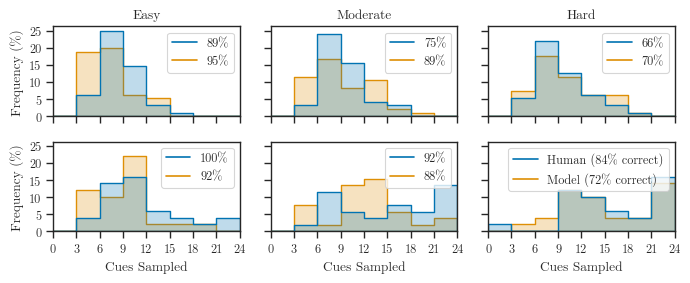

In [10]:
args1 = {'name':'tmTds_1pt3', 'pid': 1, 'delta': 0.97, 'm': 0.24, 'seed': 15, 'T': 0.65, 'tau': 0.04}
args2 = {'name':'tmTds_2pt3', 'pid': 38, 'delta': 0.57, 'm': 0.22, 'seed': 30, 'T': 0.7, 'tau': 0.04}
# run_all_trials(args1)
# run_all_trials(args2)
plot(args1['name'], args2['name'], "tmTds_fastslow3")

### Optimize T, m, and seed for PIDs 1 and 38

deltaP=0.1, trial=0
deltaP=0.1, trial=1
deltaP=0.1, trial=2
deltaP=0.1, trial=3
deltaP=0.1, trial=4
deltaP=0.1, trial=5
deltaP=0.1, trial=6
deltaP=0.1, trial=7
deltaP=0.1, trial=8
deltaP=0.1, trial=9
deltaP=0.1, trial=10
deltaP=0.1, trial=11
deltaP=0.1, trial=12
deltaP=0.1, trial=13
deltaP=0.1, trial=14
deltaP=0.1, trial=15
deltaP=0.1, trial=16
deltaP=0.1, trial=17
deltaP=0.1, trial=18
deltaP=0.1, trial=19
deltaP=0.1, trial=20
deltaP=0.1, trial=21
deltaP=0.1, trial=22
deltaP=0.1, trial=23
deltaP=0.1, trial=24
deltaP=0.1, trial=25
deltaP=0.1, trial=26
deltaP=0.1, trial=27
deltaP=0.1, trial=28
deltaP=0.1, trial=29
deltaP=0.1, trial=30
deltaP=0.1, trial=31
deltaP=0.1, trial=32
deltaP=0.1, trial=33
deltaP=0.1, trial=34
deltaP=0.1, trial=35
deltaP=0.1, trial=36
deltaP=0.1, trial=37
deltaP=0.1, trial=38
deltaP=0.1, trial=39
deltaP=0.1, trial=40
deltaP=0.1, trial=41
deltaP=0.1, trial=42
deltaP=0.1, trial=43
deltaP=0.1, trial=44
deltaP=0.1, trial=45
deltaP=0.1, trial=46
deltaP=0.1, trial=47
de

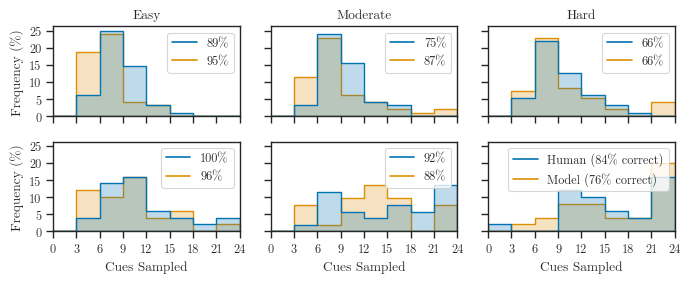

In [3]:
args1 = {'name':'tms1_pt2', 'pid': 1, 'delta':0, 'tau':0, 'm': 0.43, 'seed': 67, 'T': 0.4}
args2 = {'name':'tms2_pt2', 'pid': 38, 'delta':0, 'tau':0, 'm': 0.17, 'seed': 94, 'T': 0.27}
run_all_trials(args1)
run_all_trials(args2)
plot(args1['name'], args2['name'], "tms_fastslow2")

### Problem participants

deltaP=0.1, trial=0
deltaP=0.1, trial=1
deltaP=0.1, trial=2
deltaP=0.1, trial=3
deltaP=0.1, trial=4
deltaP=0.1, trial=5
deltaP=0.1, trial=6
deltaP=0.1, trial=7
deltaP=0.1, trial=8
deltaP=0.1, trial=9
deltaP=0.1, trial=10
deltaP=0.1, trial=11
deltaP=0.1, trial=12
deltaP=0.1, trial=13
deltaP=0.1, trial=14
deltaP=0.1, trial=15
deltaP=0.1, trial=16
deltaP=0.1, trial=17
deltaP=0.1, trial=18
deltaP=0.1, trial=19
deltaP=0.1, trial=20
deltaP=0.1, trial=21
deltaP=0.1, trial=22
deltaP=0.1, trial=23
deltaP=0.1, trial=24
deltaP=0.1, trial=25
deltaP=0.1, trial=26
deltaP=0.1, trial=27
deltaP=0.1, trial=28
deltaP=0.1, trial=29
deltaP=0.1, trial=30
deltaP=0.1, trial=31
deltaP=0.1, trial=32
deltaP=0.1, trial=33
deltaP=0.1, trial=34
deltaP=0.1, trial=35
deltaP=0.1, trial=36
deltaP=0.1, trial=37
deltaP=0.1, trial=38
deltaP=0.1, trial=39
deltaP=0.2, trial=0
deltaP=0.2, trial=1
deltaP=0.2, trial=2
deltaP=0.2, trial=3
deltaP=0.2, trial=4
deltaP=0.2, trial=5
deltaP=0.2, trial=6
deltaP=0.2, trial=7
deltaP=0.2

C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:609: UserWarning: Decoder cache could not acquire lock and was set to readonly mode.
  warnings.warn(


deltaP=0.2, trial=37
deltaP=0.2, trial=38
deltaP=0.2, trial=39
deltaP=0.2, trial=40
deltaP=0.2, trial=41
deltaP=0.2, trial=42
deltaP=0.2, trial=43
deltaP=0.2, trial=44
deltaP=0.2, trial=45
deltaP=0.2, trial=46
deltaP=0.2, trial=47
deltaP=0.2, trial=48
deltaP=0.2, trial=49
deltaP=0.2, trial=50
deltaP=0.2, trial=51
deltaP=0.2, trial=52
deltaP=0.2, trial=53
deltaP=0.2, trial=54
deltaP=0.2, trial=55
deltaP=0.2, trial=56
deltaP=0.2, trial=57
deltaP=0.2, trial=58
deltaP=0.2, trial=59
deltaP=0.2, trial=60
deltaP=0.2, trial=61
deltaP=0.2, trial=62
deltaP=0.2, trial=63
deltaP=0.2, trial=64
deltaP=0.2, trial=65
deltaP=0.2, trial=66
deltaP=0.2, trial=67
deltaP=0.2, trial=68
deltaP=0.2, trial=69
deltaP=0.2, trial=70
deltaP=0.2, trial=71
deltaP=0.2, trial=72
deltaP=0.2, trial=73
deltaP=0.2, trial=74
deltaP=0.2, trial=75
deltaP=0.2, trial=76
deltaP=0.2, trial=77
deltaP=0.2, trial=78
deltaP=0.2, trial=79
deltaP=0.2, trial=80
deltaP=0.2, trial=81
deltaP=0.2, trial=82
deltaP=0.2, trial=83
deltaP=0.2, t

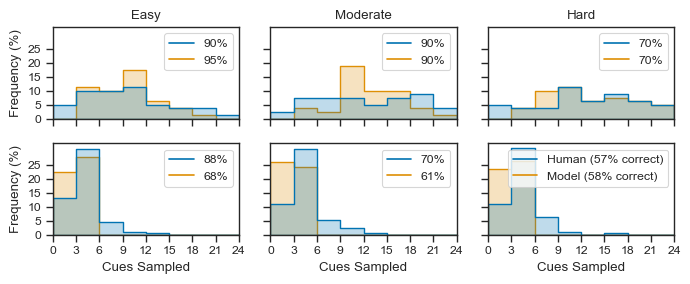

In [7]:
args1 = {'name':'tmTds_10', 'pid': 10, 'delta': 0.29, 'm': 0.33, 'seed': 57, 'T': 0.9500000000000001, 'tau': 0.07}
args2 = {'name':'tmTds_26', 'pid': 26, 'delta': 0.8200000000000001, 'm': 0.64, 'seed': 21, 'T': 0.67, 'tau': 0.18}
run_all_trials(args1)
run_all_trials(args2)
plot(args1['name'], args2['name'], "tmTds_10and26")

deltaP=0.1, trial=0
deltaP=0.1, trial=1
deltaP=0.1, trial=2
deltaP=0.1, trial=3
deltaP=0.1, trial=4
deltaP=0.1, trial=5
deltaP=0.1, trial=6
deltaP=0.1, trial=7
deltaP=0.1, trial=8
deltaP=0.1, trial=9
deltaP=0.1, trial=10
deltaP=0.1, trial=11
deltaP=0.1, trial=12
deltaP=0.1, trial=13
deltaP=0.1, trial=14
deltaP=0.1, trial=15
deltaP=0.1, trial=16
deltaP=0.1, trial=17
deltaP=0.1, trial=18
deltaP=0.1, trial=19
deltaP=0.1, trial=20
deltaP=0.1, trial=21
deltaP=0.1, trial=22
deltaP=0.1, trial=23
deltaP=0.1, trial=24
deltaP=0.1, trial=25
deltaP=0.2, trial=0
deltaP=0.2, trial=1
deltaP=0.2, trial=2
deltaP=0.2, trial=3
deltaP=0.2, trial=4
deltaP=0.2, trial=5
deltaP=0.2, trial=6
deltaP=0.2, trial=7
deltaP=0.2, trial=8
deltaP=0.2, trial=9
deltaP=0.2, trial=10
deltaP=0.2, trial=11
deltaP=0.2, trial=12
deltaP=0.2, trial=13
deltaP=0.2, trial=14
deltaP=0.2, trial=15
deltaP=0.2, trial=16
deltaP=0.2, trial=17
deltaP=0.2, trial=18
deltaP=0.2, trial=19
deltaP=0.2, trial=20
deltaP=0.2, trial=21
deltaP=0.2, 

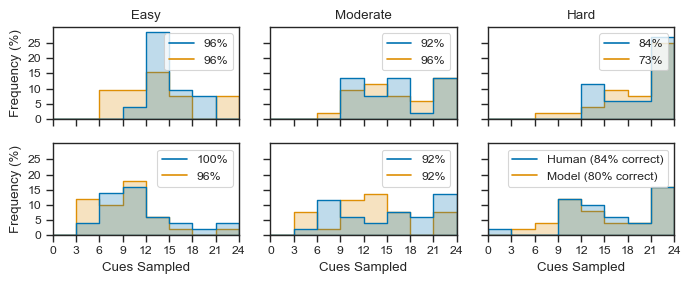

In [8]:
args1 = {'name':'tmTds_34', 'pid': 34, 'delta': 0.07, 'm': 0.23, 'seed': 52, 'T': 0.84, 'tau': 0.05}
args2 = {'name':'tmTds_38', 'pid': 38, 'delta': 0.66, 'm': 0.24, 'seed': 50, 'T': 0.67, 'tau': 0.02}
run_all_trials(args1)
run_all_trials(args2)
plot(args1['name'], args2['name'], "tmTds_34and38")

deltaP=0.1, trial=0
deltaP=0.1, trial=1
deltaP=0.1, trial=2
deltaP=0.1, trial=3
deltaP=0.1, trial=4
deltaP=0.1, trial=5
deltaP=0.1, trial=6
deltaP=0.1, trial=7
deltaP=0.1, trial=8
deltaP=0.1, trial=9
deltaP=0.1, trial=10
deltaP=0.1, trial=11
deltaP=0.1, trial=12
deltaP=0.1, trial=13
deltaP=0.1, trial=14
deltaP=0.1, trial=15
deltaP=0.1, trial=16
deltaP=0.1, trial=17
deltaP=0.1, trial=18
deltaP=0.1, trial=19
deltaP=0.1, trial=20
deltaP=0.1, trial=21
deltaP=0.1, trial=22
deltaP=0.1, trial=23
deltaP=0.1, trial=24
deltaP=0.1, trial=25
deltaP=0.1, trial=26
deltaP=0.1, trial=27
deltaP=0.1, trial=28
deltaP=0.1, trial=29
deltaP=0.1, trial=30
deltaP=0.1, trial=31
deltaP=0.1, trial=32
deltaP=0.2, trial=0
deltaP=0.2, trial=1
deltaP=0.2, trial=2
deltaP=0.2, trial=3
deltaP=0.2, trial=4
deltaP=0.2, trial=5
deltaP=0.2, trial=6
deltaP=0.2, trial=7
deltaP=0.2, trial=8
deltaP=0.2, trial=9
deltaP=0.2, trial=10
deltaP=0.2, trial=11
deltaP=0.2, trial=12
deltaP=0.2, trial=13
deltaP=0.2, trial=14
deltaP=0.2, 

C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:609: UserWarning: Decoder cache could not acquire lock and was set to readonly mode.
  warnings.warn(


deltaP=0.4, trial=15
deltaP=0.4, trial=16
deltaP=0.4, trial=17
deltaP=0.4, trial=18
deltaP=0.4, trial=19
deltaP=0.4, trial=20
deltaP=0.4, trial=21
deltaP=0.4, trial=22
deltaP=0.4, trial=23
deltaP=0.4, trial=24
deltaP=0.4, trial=25
deltaP=0.4, trial=26
deltaP=0.4, trial=27
deltaP=0.4, trial=28
deltaP=0.4, trial=29
deltaP=0.4, trial=30
deltaP=0.4, trial=31
deltaP=0.4, trial=32
deltaP=0.1, trial=0
deltaP=0.1, trial=1
deltaP=0.1, trial=2
deltaP=0.1, trial=3
deltaP=0.1, trial=4
deltaP=0.1, trial=5
deltaP=0.1, trial=6
deltaP=0.1, trial=7
deltaP=0.1, trial=8
deltaP=0.1, trial=9
deltaP=0.1, trial=10
deltaP=0.1, trial=11
deltaP=0.1, trial=12
deltaP=0.1, trial=13
deltaP=0.1, trial=14
deltaP=0.1, trial=15
deltaP=0.1, trial=16
deltaP=0.1, trial=17
deltaP=0.1, trial=18
deltaP=0.1, trial=19
deltaP=0.1, trial=20
deltaP=0.1, trial=21
deltaP=0.1, trial=22
deltaP=0.1, trial=23
deltaP=0.1, trial=24
deltaP=0.1, trial=25
deltaP=0.1, trial=26
deltaP=0.1, trial=27
deltaP=0.1, trial=28
deltaP=0.1, trial=29
de

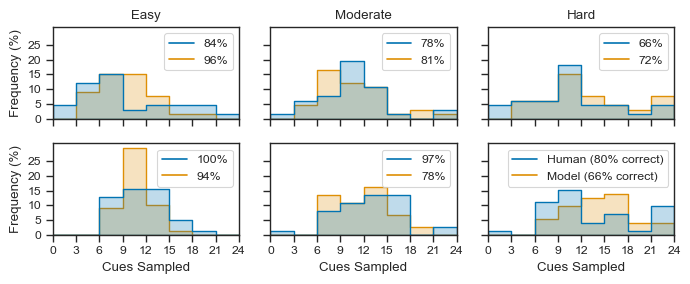

In [9]:
args1 = {'name':'tmTds_41', 'pid': 41, 'delta': 0.21, 'm': 0.25, 'seed': 99, 'T': 0.5, 'tau': 0.02}
args2 = {'name':'tmTds_55', 'pid': 55, 'delta': 0.05, 'm': 0.34, 'seed': 68, 'T': 0.9400000000000001, 'tau': 0.08}
run_all_trials(args1)
run_all_trials(args2)
plot(args1['name'], args2['name'], "tmTds_41and55")

## Rerun all trials for the fast individual

In [4]:
args = {'pid': 1, 'delta': 0.08, 'm': 0.02, 'seed': 760, 'T': 0.89, 'tau': 0.25}
run_all_trials(args, name='tmTds_fast_abs')

deltaP=0.1, trial=0
deltaP=0.1, trial=1
deltaP=0.1, trial=2
deltaP=0.1, trial=3
deltaP=0.1, trial=4
deltaP=0.1, trial=5
deltaP=0.1, trial=6
deltaP=0.1, trial=7
deltaP=0.1, trial=8
deltaP=0.1, trial=9
deltaP=0.1, trial=10
deltaP=0.1, trial=11
deltaP=0.1, trial=12
deltaP=0.1, trial=13
deltaP=0.1, trial=14
deltaP=0.1, trial=15
deltaP=0.1, trial=16
deltaP=0.1, trial=17
deltaP=0.1, trial=18
deltaP=0.1, trial=19
deltaP=0.1, trial=20
deltaP=0.1, trial=21
deltaP=0.1, trial=22
deltaP=0.1, trial=23
deltaP=0.1, trial=24
deltaP=0.1, trial=25
deltaP=0.1, trial=26
deltaP=0.1, trial=27
deltaP=0.1, trial=28
deltaP=0.1, trial=29
deltaP=0.1, trial=30
deltaP=0.1, trial=31
deltaP=0.1, trial=32
deltaP=0.1, trial=33
deltaP=0.1, trial=34
deltaP=0.1, trial=35
deltaP=0.1, trial=36
deltaP=0.1, trial=37
deltaP=0.1, trial=38
deltaP=0.1, trial=39
deltaP=0.1, trial=40
deltaP=0.1, trial=41
deltaP=0.1, trial=42
deltaP=0.1, trial=43
deltaP=0.1, trial=44
deltaP=0.1, trial=45
deltaP=0.1, trial=46
deltaP=0.1, trial=47
de

In [68]:
args = {'pid': 1,  'delta': 0.82, 'm': 0.39, 'seed': 86, 'T': 0.87, 'tau': 0.06}
run_all_trials(args, name='hist_fast')

deltaP=0.1, trial=0
deltaP=0.1, trial=1
deltaP=0.1, trial=2
deltaP=0.1, trial=3
deltaP=0.1, trial=4
deltaP=0.1, trial=5
deltaP=0.1, trial=6
deltaP=0.1, trial=7
deltaP=0.1, trial=8
deltaP=0.1, trial=9
deltaP=0.1, trial=10
deltaP=0.1, trial=11
deltaP=0.1, trial=12
deltaP=0.1, trial=13
deltaP=0.1, trial=14
deltaP=0.1, trial=15
deltaP=0.1, trial=16
deltaP=0.1, trial=17
deltaP=0.1, trial=18
deltaP=0.1, trial=19
deltaP=0.1, trial=20
deltaP=0.1, trial=21
deltaP=0.1, trial=22
deltaP=0.1, trial=23
deltaP=0.1, trial=24
deltaP=0.1, trial=25
deltaP=0.1, trial=26
deltaP=0.1, trial=27
deltaP=0.1, trial=28
deltaP=0.1, trial=29
deltaP=0.1, trial=30
deltaP=0.1, trial=31
deltaP=0.1, trial=32
deltaP=0.1, trial=33
deltaP=0.1, trial=34
deltaP=0.1, trial=35
deltaP=0.1, trial=36
deltaP=0.1, trial=37
deltaP=0.1, trial=38
deltaP=0.1, trial=39
deltaP=0.1, trial=40
deltaP=0.1, trial=41
deltaP=0.1, trial=42
deltaP=0.1, trial=43
deltaP=0.1, trial=44
deltaP=0.1, trial=45
deltaP=0.1, trial=46
deltaP=0.1, trial=47
si

## Run all trials for slow individual

In [69]:
args = {'pid': 38, 'delta': 0.21, 'm': 0.23, 'seed': 97, 'T': 0.75, 'tau': 0.05}
run_all_trials(args, name='hist_slow')

deltaP=0.1, trial=0
deltaP=0.1, trial=1
deltaP=0.1, trial=2
deltaP=0.1, trial=3
deltaP=0.1, trial=4
deltaP=0.1, trial=5
deltaP=0.1, trial=6
deltaP=0.1, trial=7
deltaP=0.1, trial=8
deltaP=0.1, trial=9
deltaP=0.1, trial=10
deltaP=0.1, trial=11
deltaP=0.1, trial=12
deltaP=0.1, trial=13
deltaP=0.1, trial=14
deltaP=0.1, trial=15
deltaP=0.1, trial=16
deltaP=0.1, trial=17
deltaP=0.1, trial=18
deltaP=0.1, trial=19
deltaP=0.1, trial=20
deltaP=0.1, trial=21
deltaP=0.1, trial=22
deltaP=0.1, trial=23
deltaP=0.1, trial=24
simulated [0 0 1 5 5 3 2 8]
empirical [1 0 0 6 5 3 2 8]
loss 2.090909090909091
deltaP=0.2, trial=0
deltaP=0.2, trial=1
deltaP=0.2, trial=2
deltaP=0.2, trial=3
deltaP=0.2, trial=4
deltaP=0.2, trial=5
deltaP=0.2, trial=6
deltaP=0.2, trial=7
deltaP=0.2, trial=8
deltaP=0.2, trial=9
deltaP=0.2, trial=10
deltaP=0.2, trial=11
deltaP=0.2, trial=12
deltaP=0.2, trial=13
deltaP=0.2, trial=14
deltaP=0.2, trial=15
deltaP=0.2, trial=16
deltaP=0.2, trial=17
deltaP=0.2, trial=18
deltaP=0.2, trial

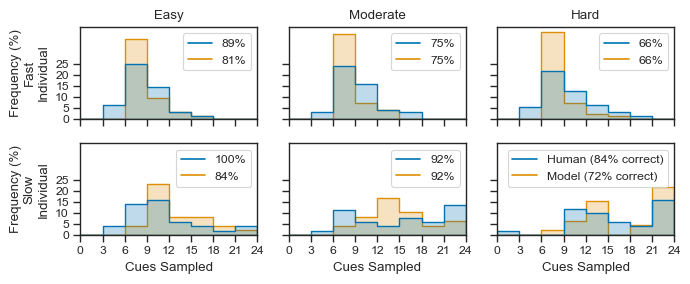

In [7]:
plot("tmTds_fast_abs", "38", "tmTDs_fast_abs")

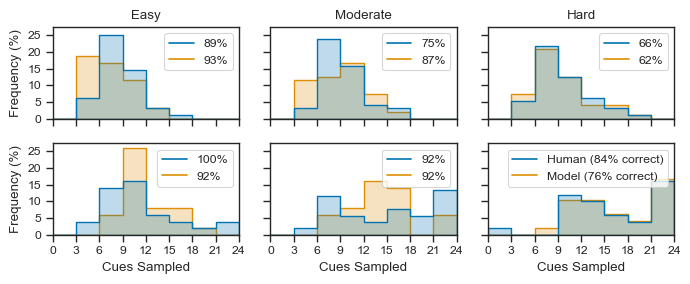

In [96]:
plot("hist_fast", "hist_slow", "hist")

In [9]:
print(len(pd.read_pickle("data/empirical.pkl")['participant_id'].unique()))

57


In [12]:
with open('data/pids.pkl', 'rb') as f:
    pids = pickle.load(f)
print(list(pids.keys()))

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56]


## Paper Figures

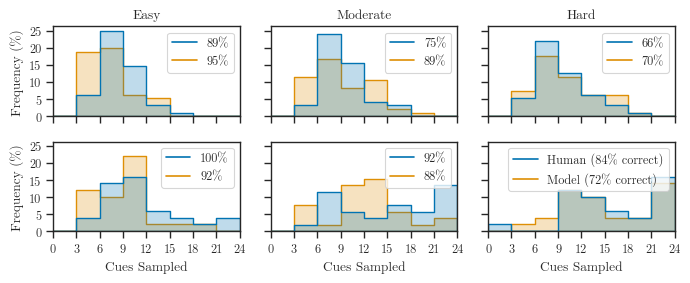

In [3]:
args1 = {'name':'tmTds_1pt3', 'pid': 1, 'delta': 0.97, 'm': 0.24, 'seed': 15, 'T': 0.65, 'tau': 0.04}
args2 = {'name':'tmTds_2pt3', 'pid': 38, 'delta': 0.57, 'm': 0.22, 'seed': 30, 'T': 0.7, 'tau': 0.04}
# run_all_trials(args1)
# run_all_trials(args2)
plot(args1['name'], args2['name'], "tmTds_fastslow3")